<a href="https://colab.research.google.com/github/raneldan/ALRP/blob/main/LP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Licence Plate Recognition**

---

**This project detects licence plate in pictures**

High-level design:

Given image, we first identify the licence plate inside the image, then the cropped picture of the licence plate is going thought series of diffrent filters in order to preper it to the symbol recognition.

Finally the proccesed image is given to OCR model which outputs the predicted licence plate characters.


In [ ]:
# installations

!sudo apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract
!pip install Pillow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,788 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
# This Colab requires TF 2.5.
!pip install -U tensorflow>=2.5

# imports

import pathlib
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from collections import namedtuple
from google.colab import drive
from google.colab.patches import cv2_imshow
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext,basename
from tensorflow.keras.models  import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import pytesseract
import shutil
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
import glob
import pytesseract
import shutil
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
import re

tf.get_logger().setLevel('ERROR')

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# THIS IS THE BASE PATH, ALL OTHER PATH IS RELATIVE TO THIS ONE
# THIS PATH SHOULD BE PRE-EXIST IN GOOGLE DRIVE 
basePath = "/content/gdrive/MyDrive/Colab Notebooks/LP-Project"

In [ ]:
# Functions to retrive the true lables from the dataset

def processFileName(file):
  file = file.rsplit('/')[-1]
  file = file.rsplit('.', 1)[0]
  return(int(file))

def readLPFile(file):
  LP = ""
  with open(file) as file:
      for line in file:
        line = line.rstrip('\n')
        LP += linet
  return (LP)

def createTags():
  labelsPath = basePath + "/dataset/labels/"
  tags = []
  files = [labelsPath + x for x in os.listdir(labelsPath)]
  for file in files:
    if file.endswith(".txt"):
      tag = readLPFile(file)
      file = processFileName(file)
      tags.append([file, tag])
  return (tags)


In [ ]:
# Util functions for the LP detection model

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (840, 400)
    two_lines = (840, 400)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor


In [ ]:
# This function detect LP inside the input image (I), using the provided model

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        return model
    except Exception as e:
        print(e)
wpod_net_path = basePath + "/code/models/wpod-net.json"
wpod_net = load_model(wpod_net_path)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [ ]:
# This function gets the path the image and save the cropped image (with the same name) of the plate to the pre-determined path
def getPlateFromImage(path, name):
  vehicle, LpImg, cor = get_plate(path)
  plt.axis(False)
  plt.imshow(LpImg[0])
  pathToPlate = basePath + "/dataset/plates/"
  pathToPlate += str(name) + '.jpg'
  plt.savefig(pathToPlate, bbox_inches='tight')
  return (pathToPlate)

In [ ]:
# This function gets the path to the plate image, and preprocess it in order to make it easier to the OCR model to recognize the symbols in the picture
# We use many diffrent filters here
def imagePreProcessing(pathToPlate):
  img = cv2.imread(pathToPlate)
  img = cv2.resize(img, None, fx=2, fy=1.4, interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, (21, 21), 2)
  img = cv2.adaptiveThreshold(cv2.GaussianBlur(img, (19, 19), 0), 199, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 2)
  cv2_imshow(img)

  path = 'temp.jpg'
  cv2.imwrite(path, img)
  return (path)

In [ ]:
# This fucntion gets the path to the image and return the text returned form running the OCR model on the image
def applyOCR(path):
  pytessConfig = '--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
  text = pytesseract.image_to_string(Image.open(path), config = pytessConfig)
  return (text)

In [ ]:
# This function make sure the prediction satisfy the licence plate template => 6 characters from A-Z U 0-9
def cleanPrediction(plate):
  plate = plate.upper()
  plate = re.sub("[^0-9A-Za-z]" , "", plate)
  return(plate[:6])

In [ ]:
# This function get 2 lists - the predictions and the true label and returns the success rate
def compareResults(labels, predictions):
  labels.sort()
  predictions.sort()
  sum = 0
  for pred in predictions:
    imageNum = pred[0] - 1
    sum += comparePlate(labels[imageNum][1], pred[1])
  print (sum / (6 * len(predictions)))

In [ ]:
# This function get a single pair of prediction and label and return the number of matched characters
def comparePlate(label, prediction):
  print("true label ", label)
  print("prediction ", prediction)
  print()
  label = set(label)
  prediction = set(prediction)
  return(len(label & prediction))

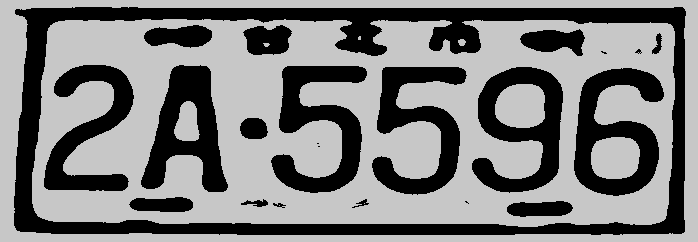

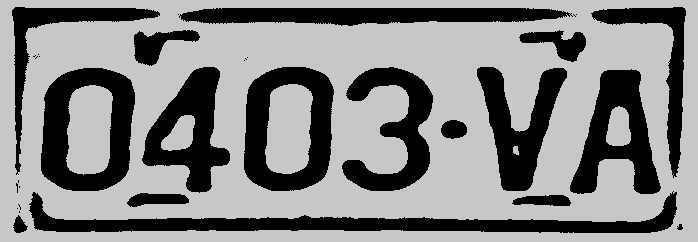

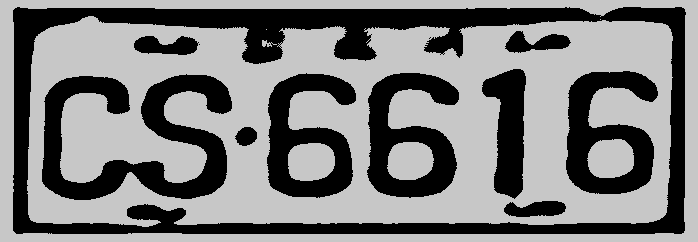

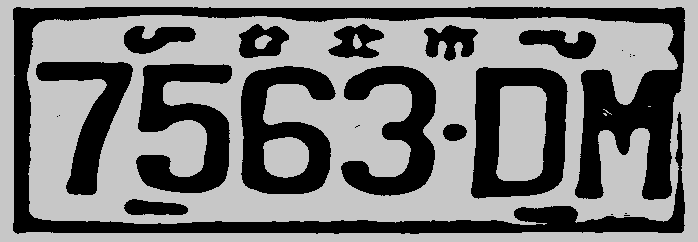

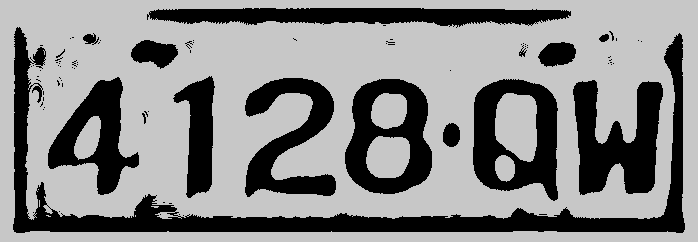

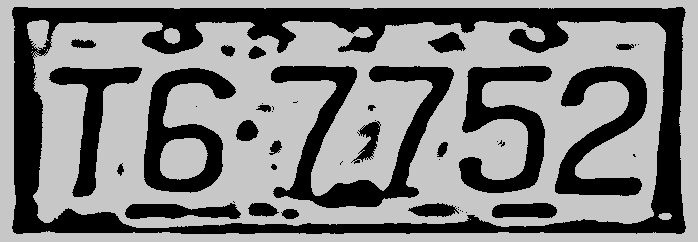

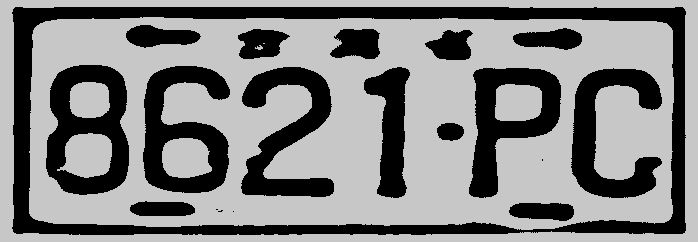

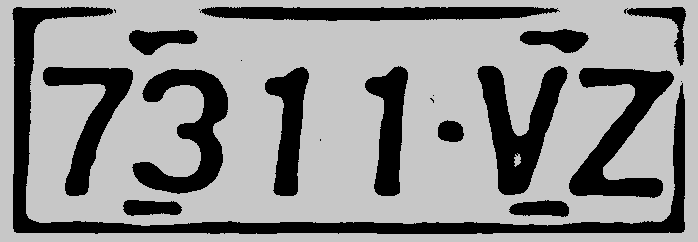

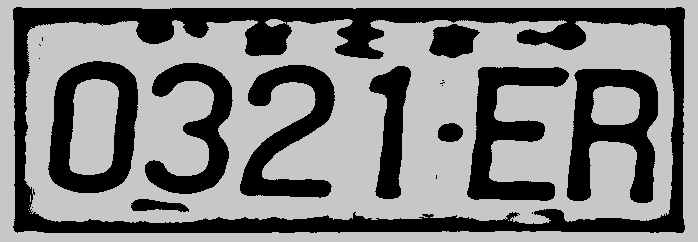

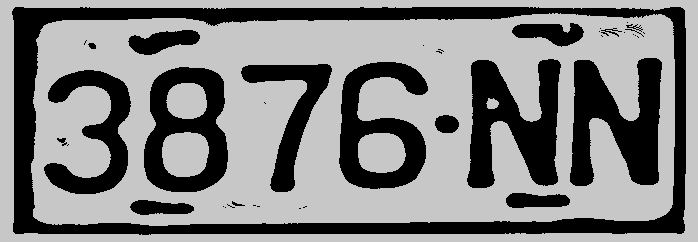

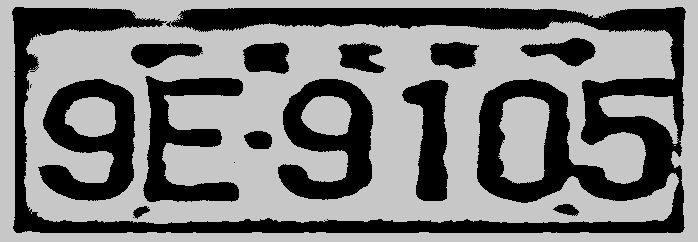

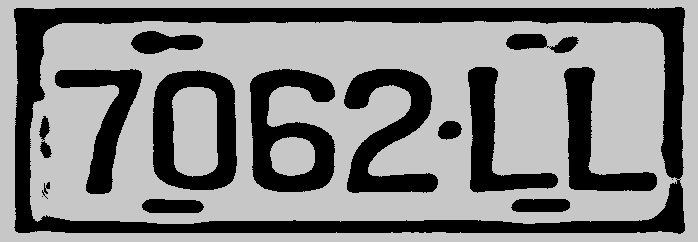

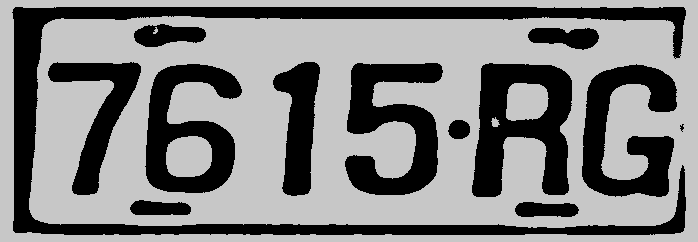

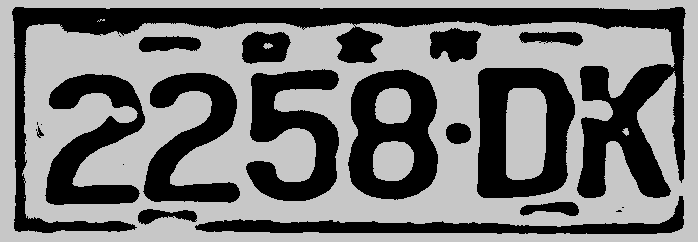

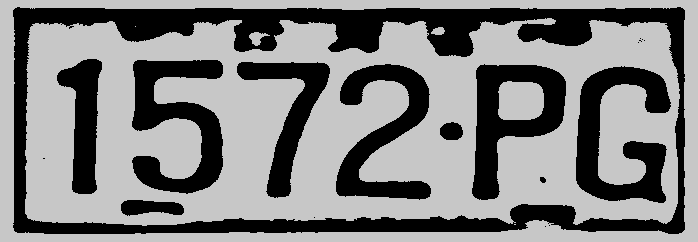

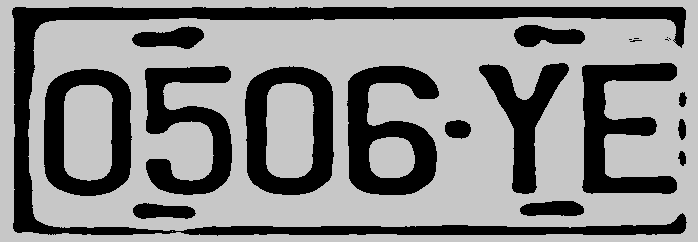

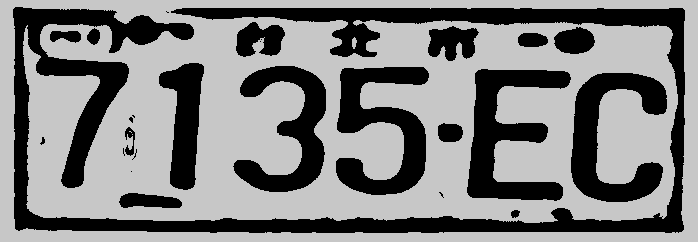

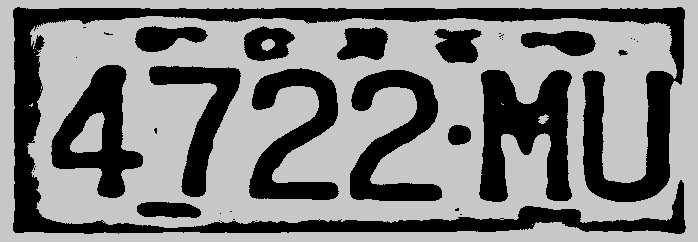

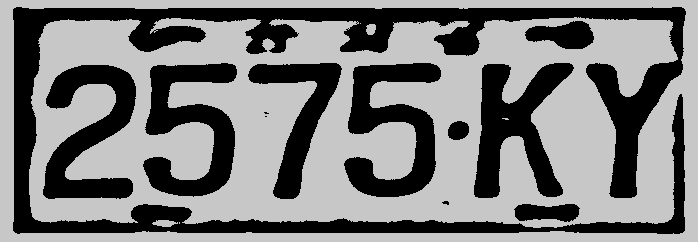

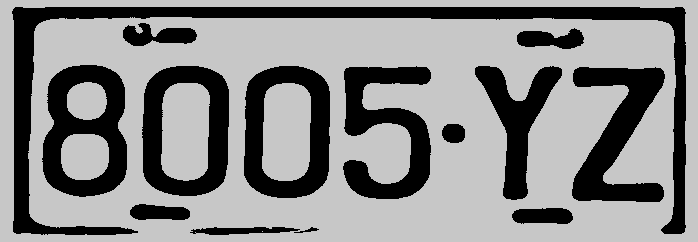

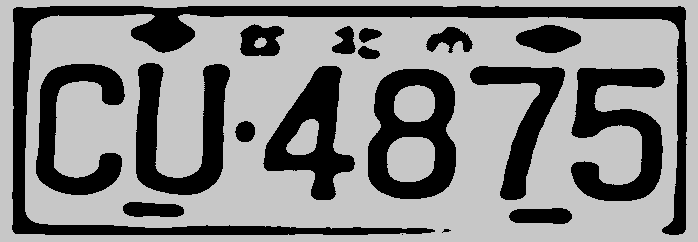

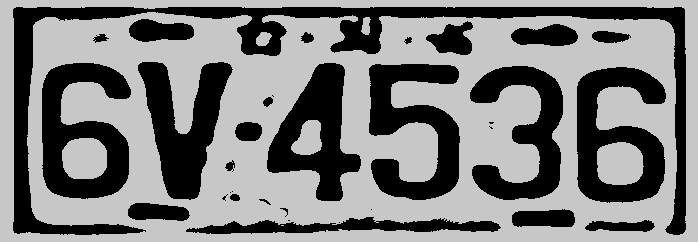

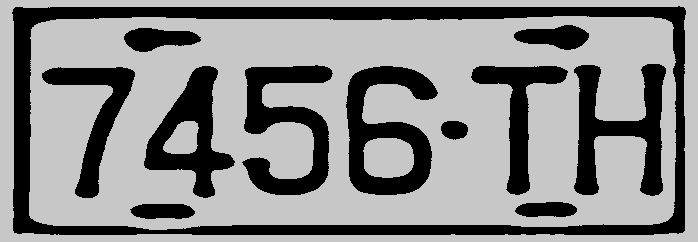

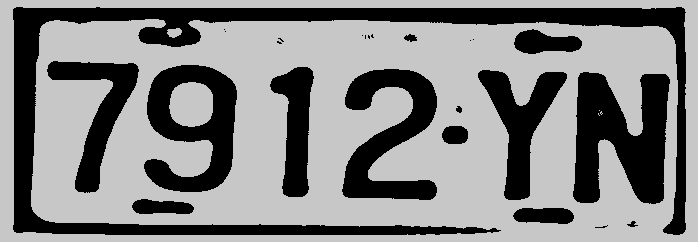

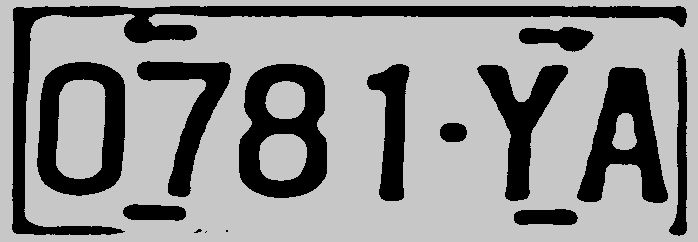

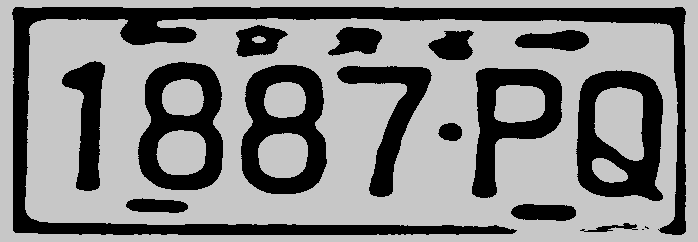

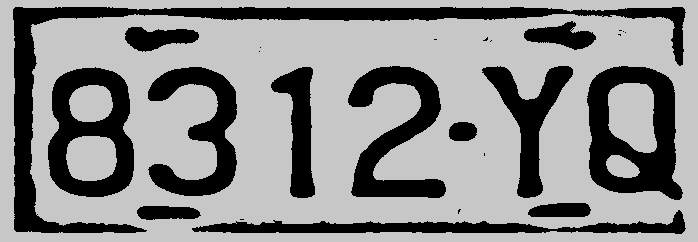

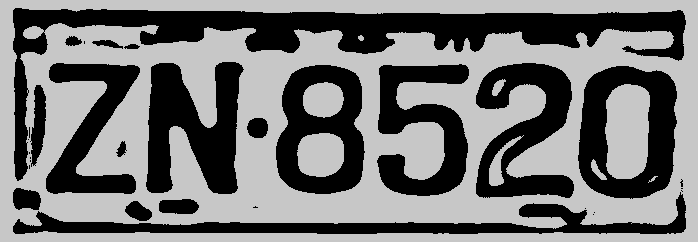

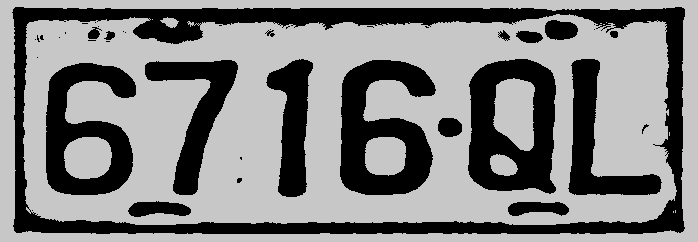

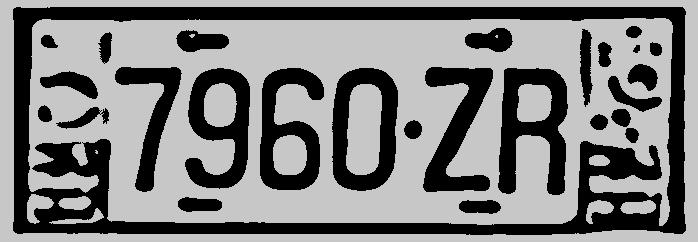

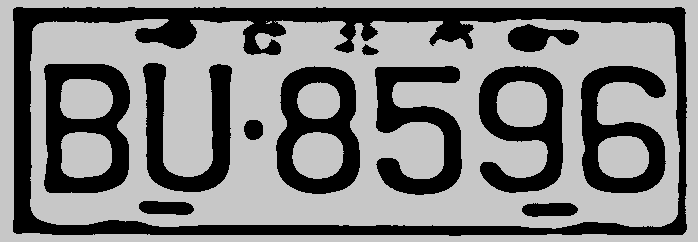

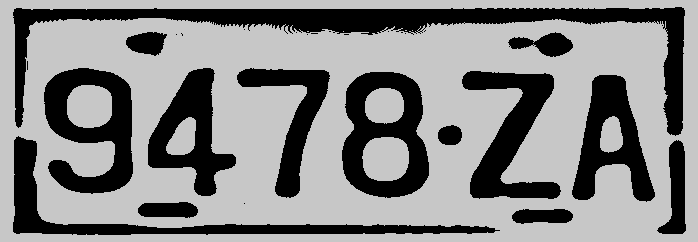

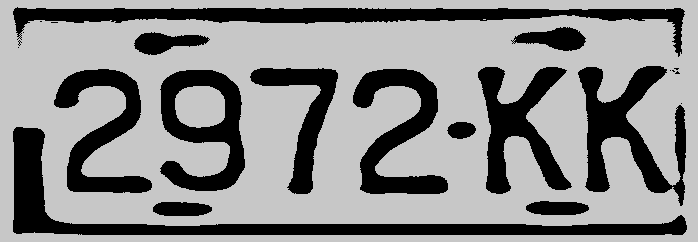

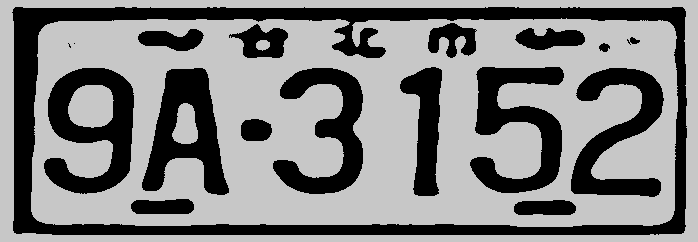

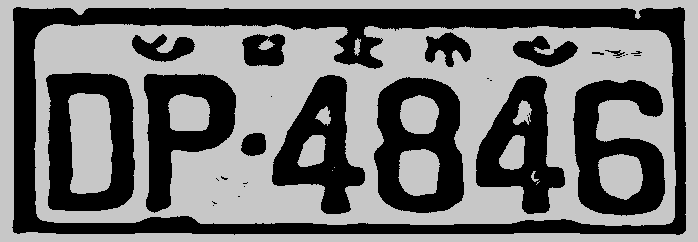

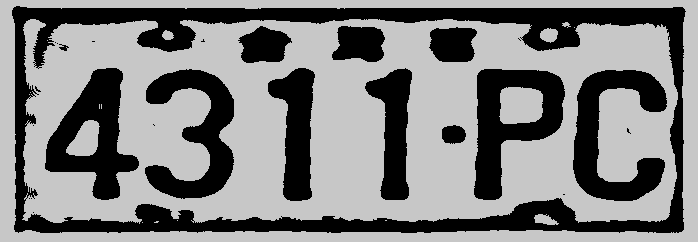

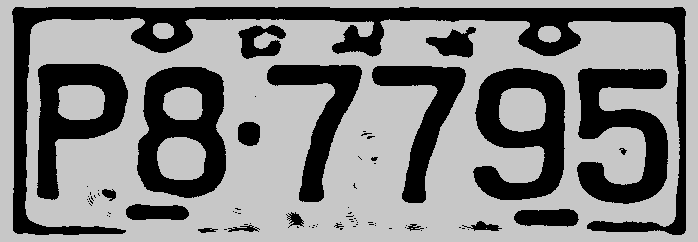

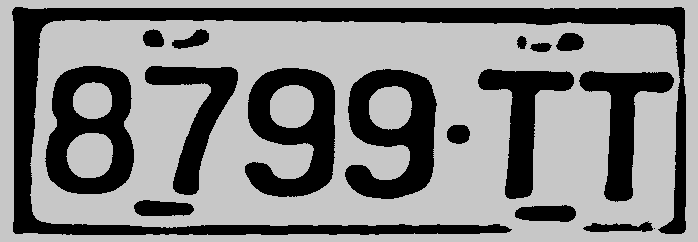

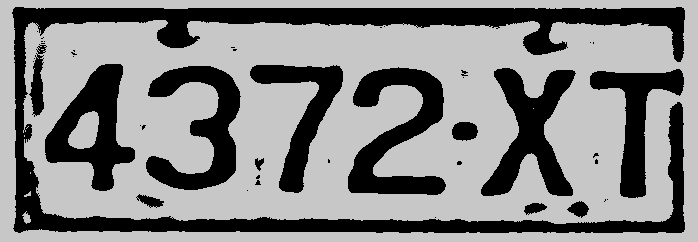

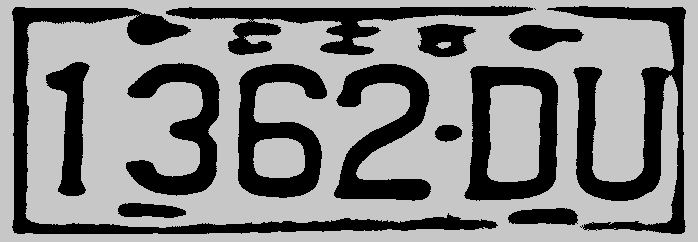

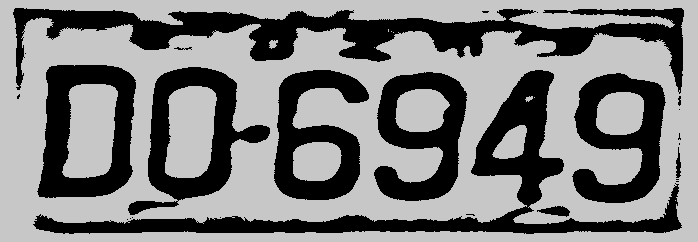

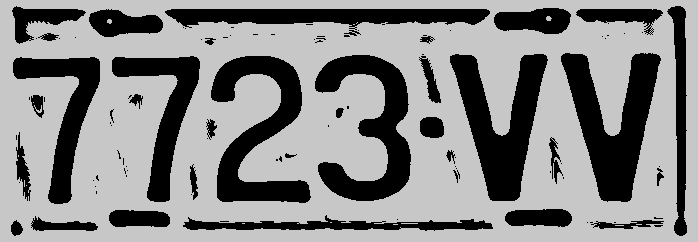

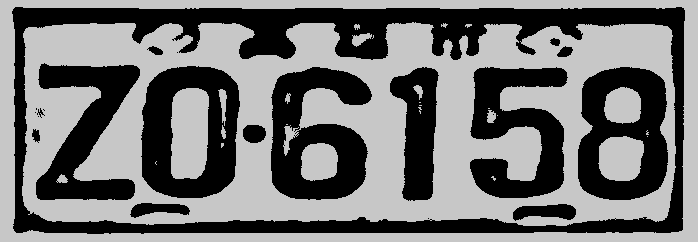

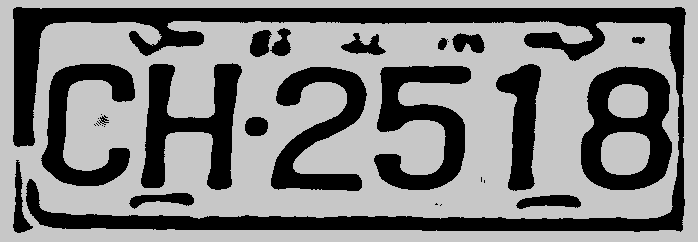

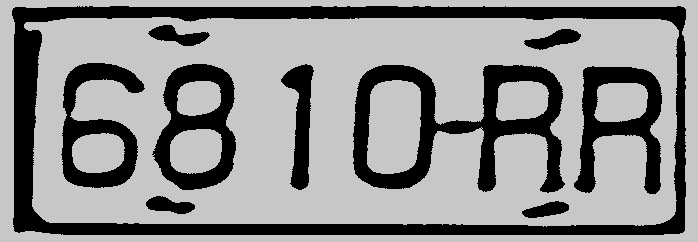

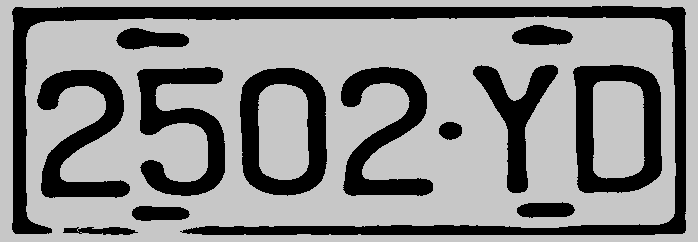

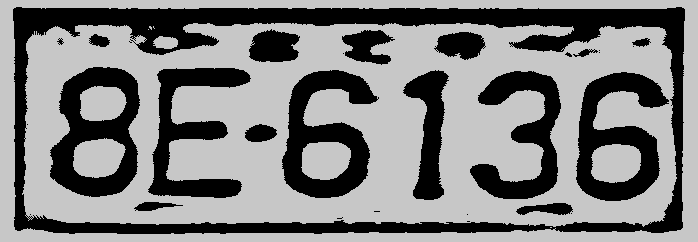

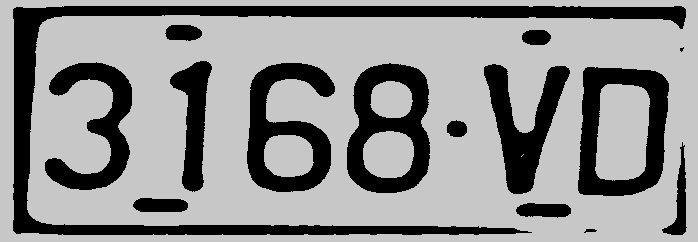

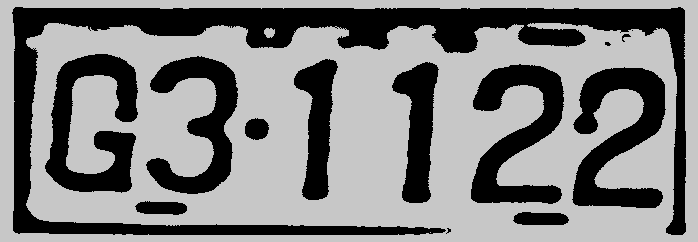

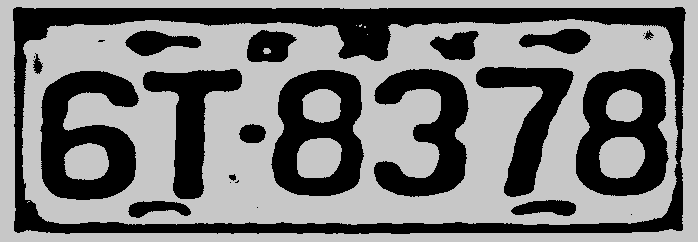

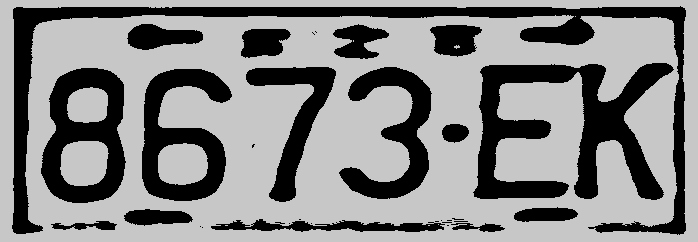

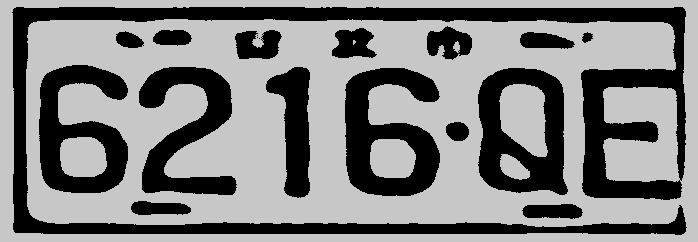

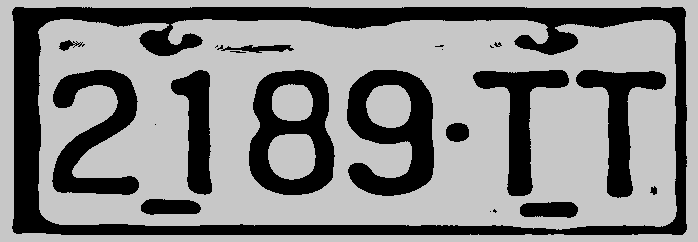

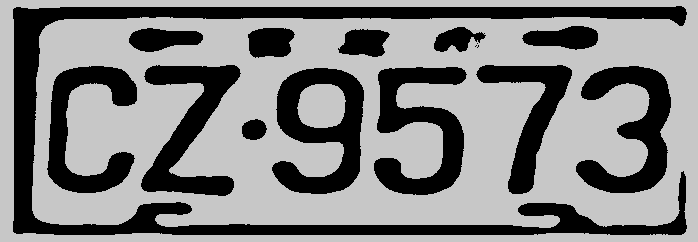

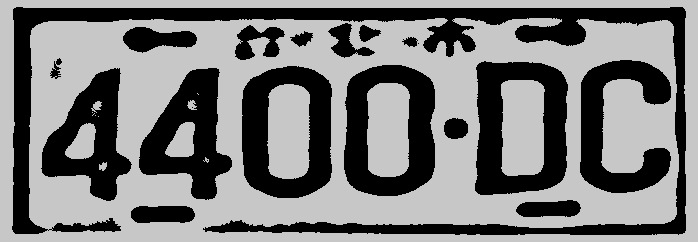

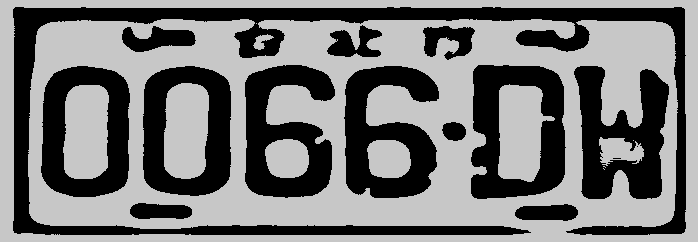

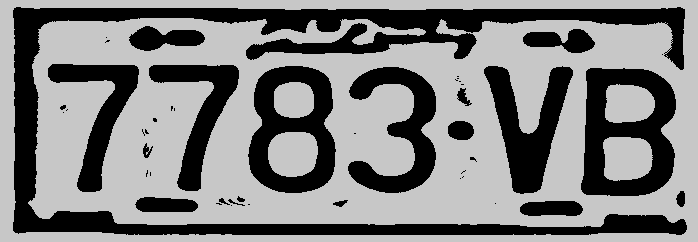

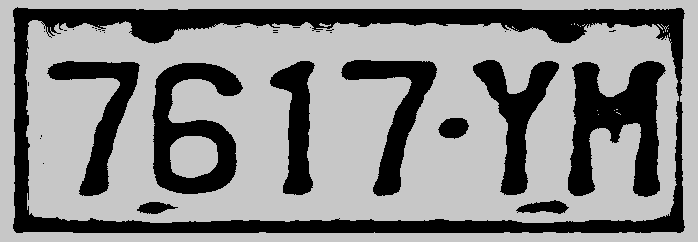

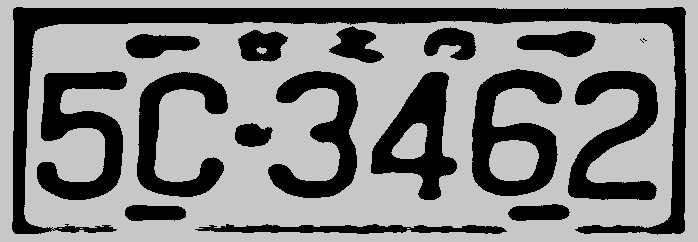

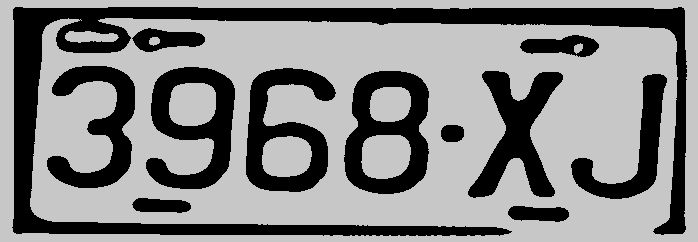

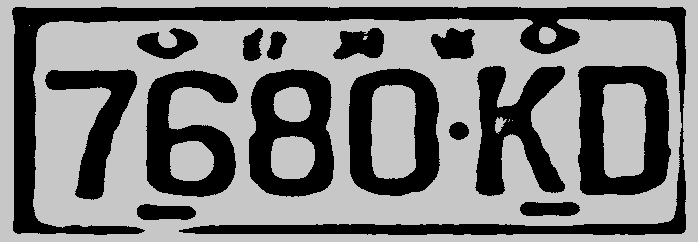

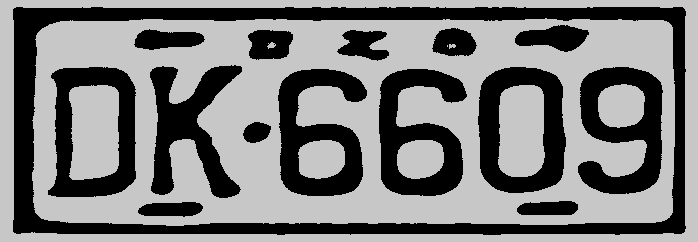

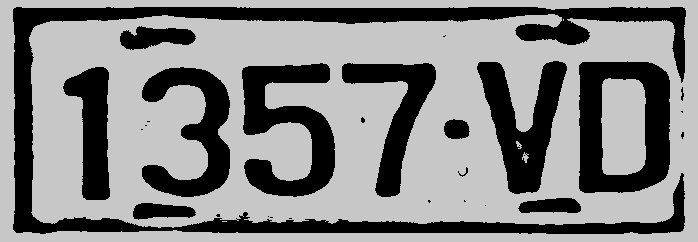

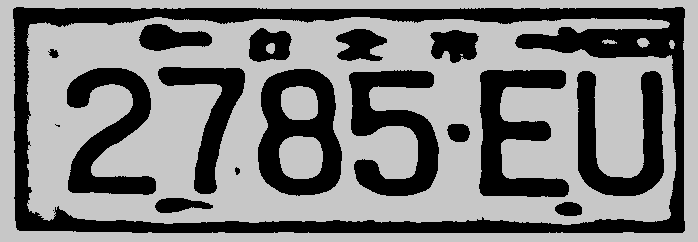

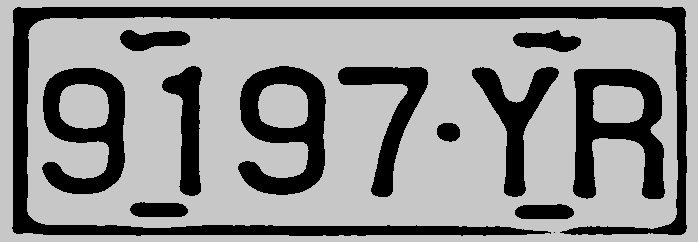

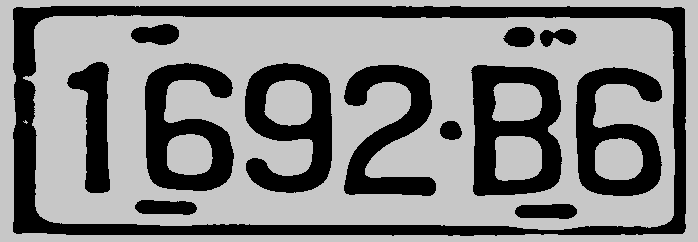

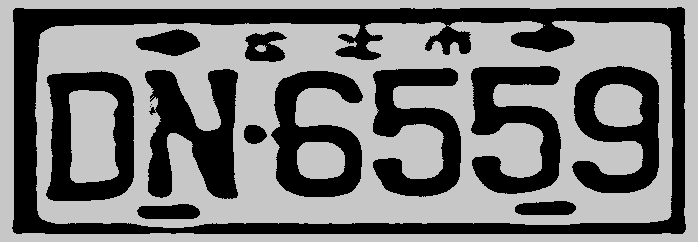

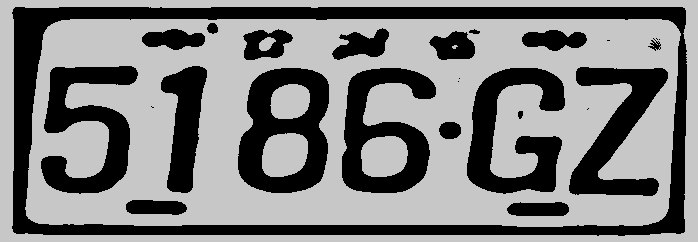

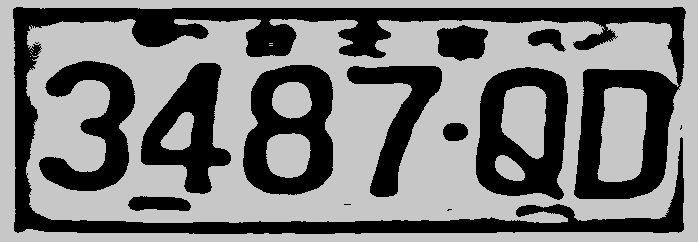

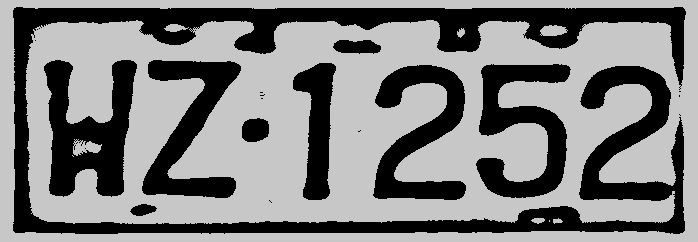

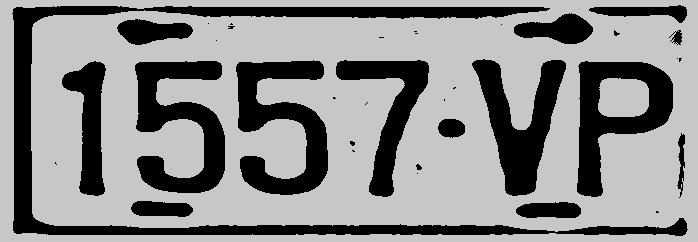

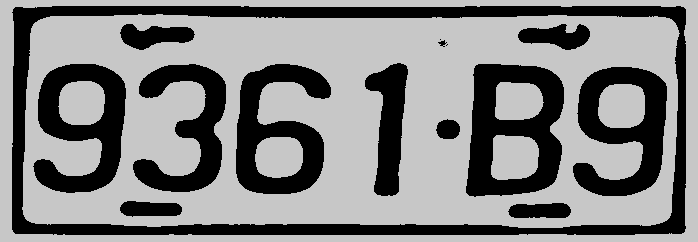

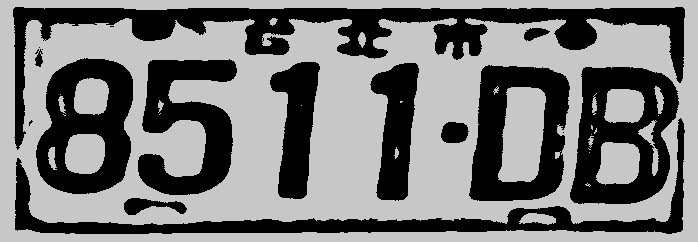

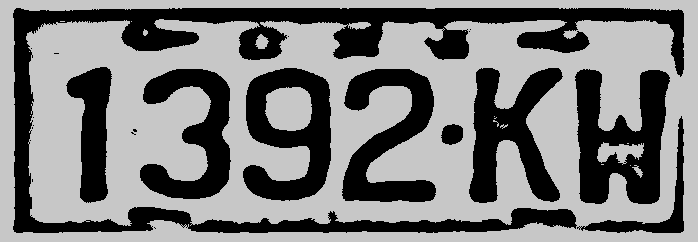

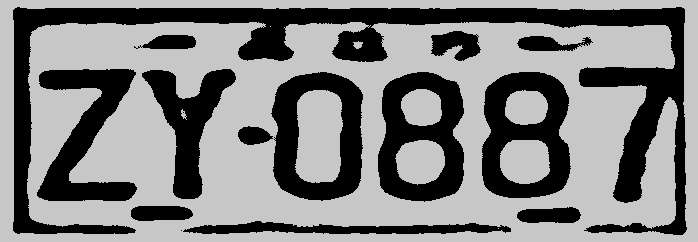

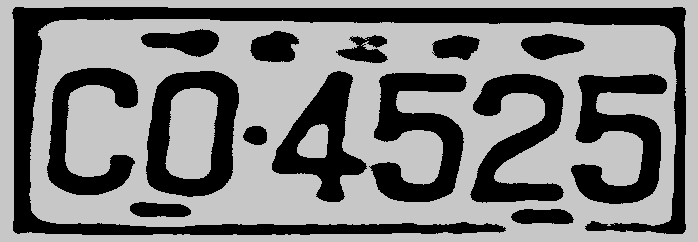

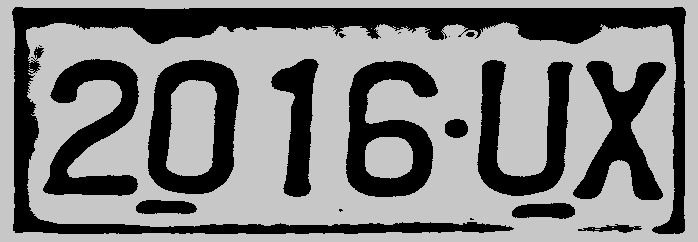

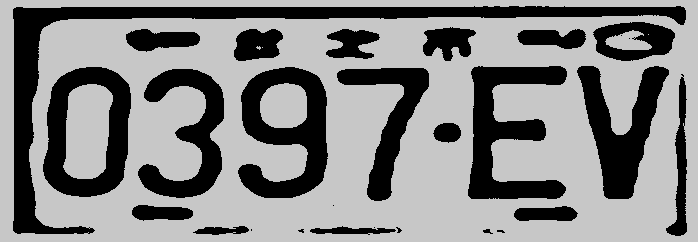

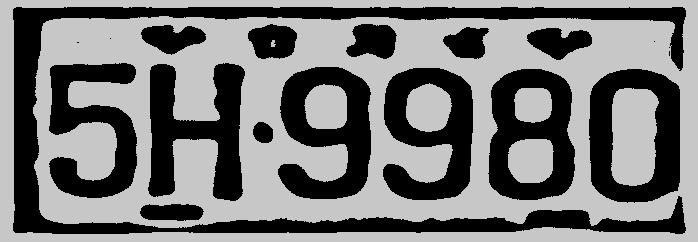

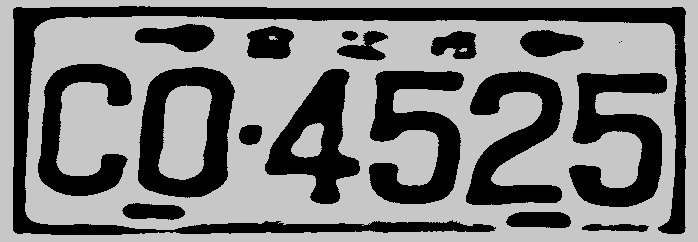

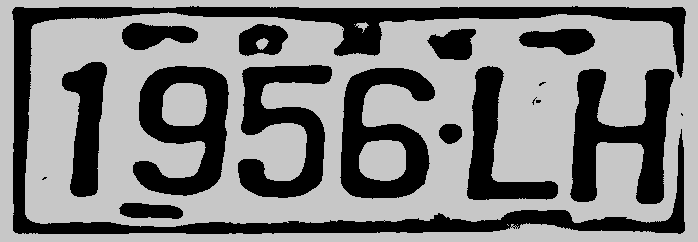

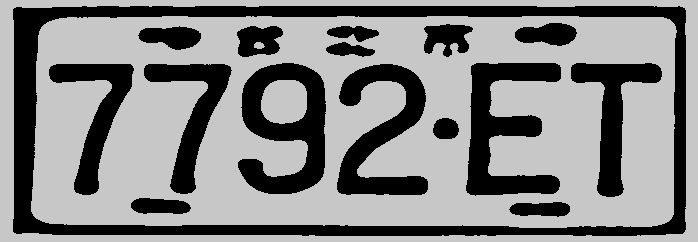

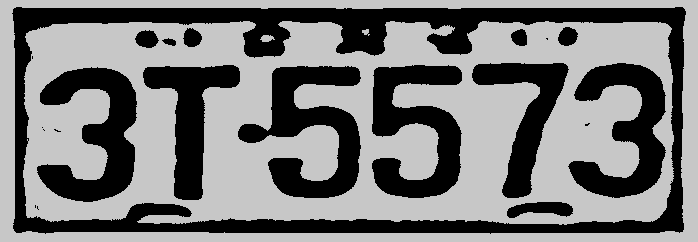

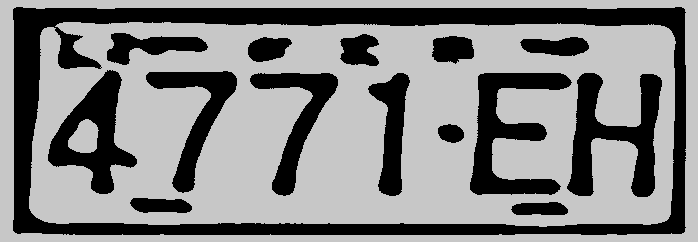

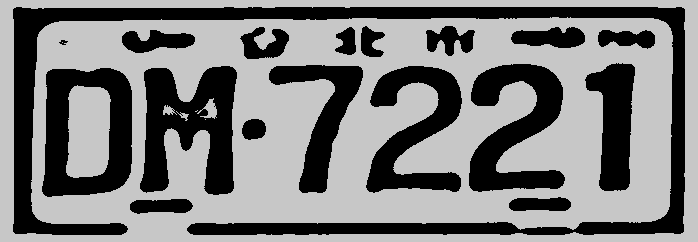

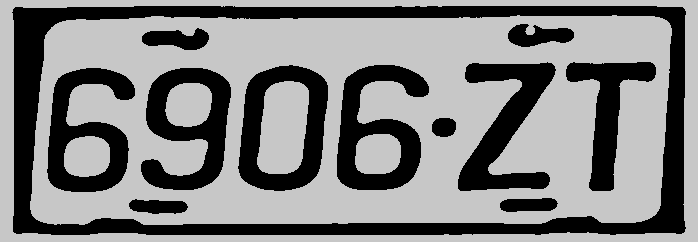

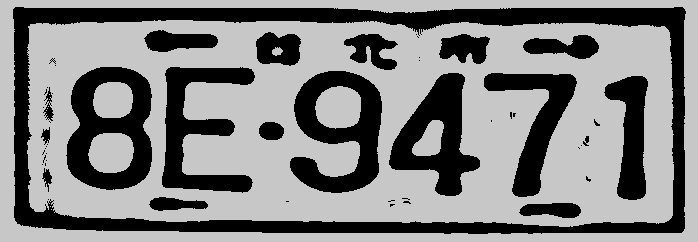

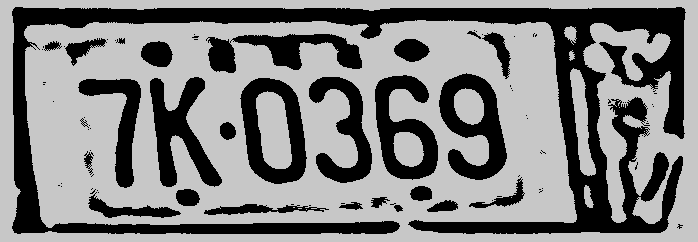

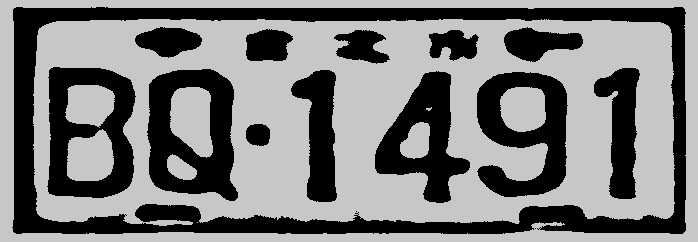

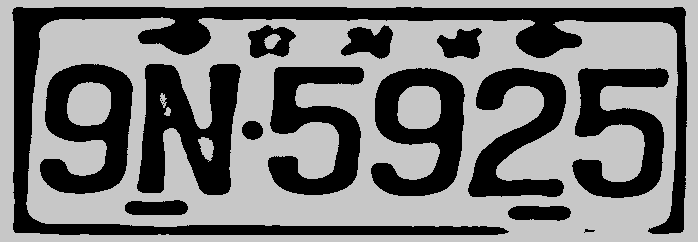

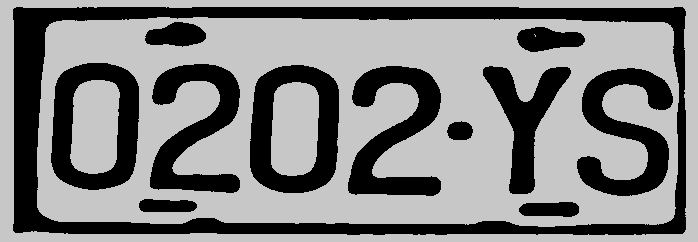

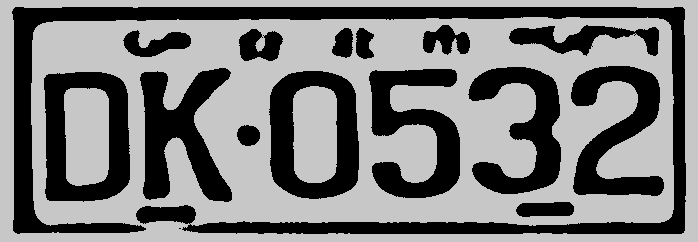

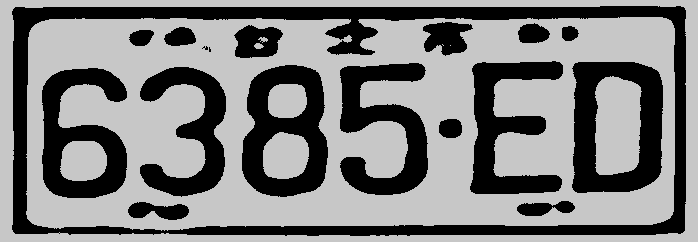

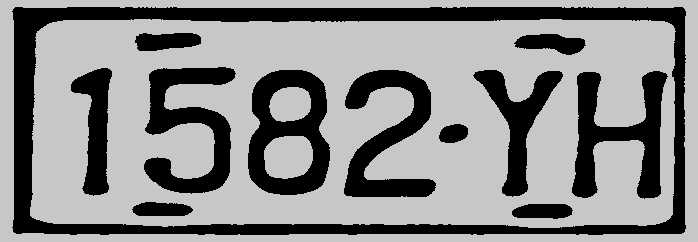

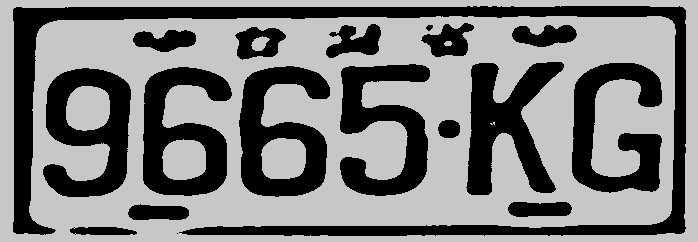

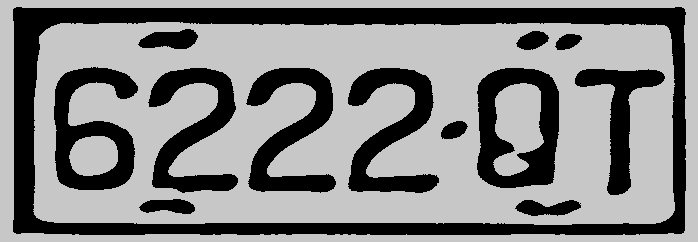

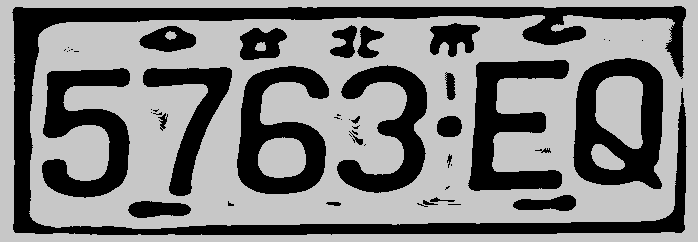

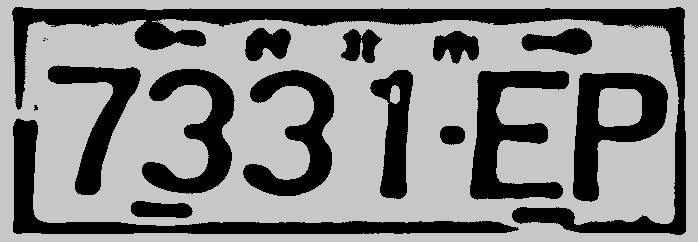

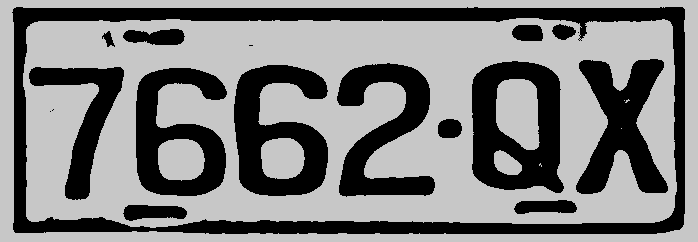

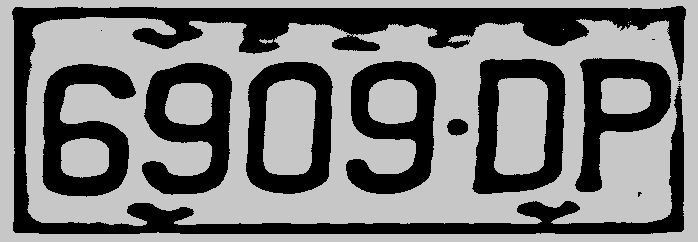

true label  0781YA
prediction  L0781Y

true label  2258DK
prediction  2258DI

true label  2972KK
prediction  12372K

true label  Z06158
prediction  706158

true label  7783VB
prediction  7783VB

true label  CZ9573
prediction  ICZ957

true label  0397EV
prediction  LO397E

true label  5H9980
prediction  I5H998

true label  6222QT
prediction  62220T

true label  0321ER
prediction  0321ER

true label  7615RG
prediction  7615AG

true label  2A5596
prediction  2A5596

true label  7960ZR
prediction  279602

true label  1572PG
prediction  1572PG

true label  7456TH
prediction  7456TH

true label  4722MU
prediction  L4722M

true label  8005YZ
prediction  I8005Y

true label  1887PQ
prediction  11887P

true label  7135EC
prediction  7135EC

true label  BU8596
prediction  BU8596

true label  0506YE
prediction  L0506Y

true label  8312YQ
prediction  IG312Y

true label  7912YN
prediction  7912YN

true label  CU4875
prediction  CU4875

true label  ZN8520
prediction  IZN852

true label  6716QL
predic

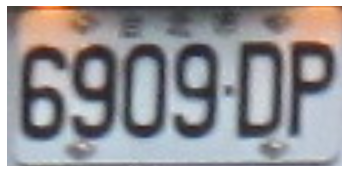

In [ ]:
# Main code - run all over functions
trueLabesls = createTags()
predictions = []
imagesPath = basePath + "/dataset/images/"
files = [imagesPath + x for x in os.listdir(imagesPath)]
for file in files:
  if file.endswith(".jpg"):
    path = getPlateFromImage(file, processFileName(file))
    img = imagePreProcessing(path)
    result = applyOCR(img)
    predictions.append([processFileName(file),cleanPrediction(result)])
compareResults(trueLabesls, predictions)